In [17]:
import numpy as np
import copy
import pandas as pd
from gym_ur.game_of_ur2 import GoUrEnv
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
import dill
import os.path
plt.style.use('ggplot')

In [18]:
def eGreedyActionSelection(env, q_curr, eps, possible_actions, movable_piece_board_pos):
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        env: Environment
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        The selected action.
    '''
    if np.random.rand() < (1 - eps):
        best_val = np.max(q_curr)
        b_actions=np.arange(q_curr.size, dtype=int)[q_curr==best_val]
        best_action = np.random.choice(b_actions)
        if best_action in movable_piece_board_pos.keys():
            return movable_piece_board_pos[best_action]
        
    return np.random.choice(possible_actions)

In [19]:
# create environment
env = GoUrEnv(4)

In [20]:
def updateMCValues(Q_func, policy, episode_transitions, gamma, alpha):
    '''
    Updates the Q-function according to the given episode transitions.
    
    Args:
        Q_func: A dictonary mapping state -> action values.
        episode_transitions: A list of (state, action, reward) tuples describing the episode.
        gamma: The discount factor.
        alpha: The stepsize.
        
    Returns:
        The updated Q-function.
    '''
    G = 0
    episode_transitions = episode_transitions[::-1]
    for state, action, reward in episode_transitions:
        G = reward + (gamma * G)
        Q_func[state][action] += (alpha * (G - Q_func[state][action])) 
    return Q_func

In [25]:
def train_mc_agent(env, num_episodes, q1, ep1, ep2, eps=0.1, gamma=1.0, alpha=0.1, logging=False):
    player1 = 0
    player2 = 1
    init_q_value = 0.0
    policy = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
    episode_value_func = []
    v_s = ((3, (('a', 3),)), (3, (('c', 3),)), 1)
    
    # check for pickles
    if q1 == None:
        Q_func_1 = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
    else:
        Q_func_1 = q1

    
    episode_rewards_p1 = ep1
    episode_rewards_p2 = ep2
    time_to_win = []
    for curr_episode in range(num_episodes):
#         value_func = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
        episode_transitions = list()
        episode_transitions_p2 = list()
        dice_up = env.roll()
        state = env.reset(dice_up)
        is_done = False
        t = 0
        if logging:
            print(curr_episode)
            
        while True:
            # player 1 move
            t += 1
            
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player1, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q_func_1[state], eps, possible_actions, movable_piece_board_pos)
                new_state, reward_p1, done, _ = env.step(action, dice_up)
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                episode_transitions.append((state, action['board_pos'], reward_p1))
                state = copy.deepcopy(new_state)
                
                if done:
                    break
           
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player2, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q_func_1[state], eps, possible_actions, movable_piece_board_pos)
                new_state, reward_p2, done, _ = env.step(action, dice_up)
                episode_transitions.append((state, action['board_pos'], reward_p2))
                state = copy.deepcopy(new_state)

                if done:
                    break
            
            if logging:
                print(state, reward, done)
        
            dice_up = env.roll() # player 1 roll
            
        episode_rewards_p1[-1] =+ reward_p1
        episode_rewards_p1.append(0.0)
        
        episode_rewards_p2[-1] =+ reward_p2
        episode_rewards_p2.append(0.0)
        time_to_win.append(t)
        
        # Update the Q functions
        Q_func_1 = updateMCValues(Q_func_1, policy, episode_transitions, gamma, alpha)
        poli = np.argmax(Q_func_1[v_s])
        episode_value_func.append(Q_func_1[v_s][poli])
    
    return Q_func_1, policy, episode_rewards_p1, episode_rewards_p2, time_to_win, episode_value_func

In [26]:
episode_rwds_p1 = []
episode_rwds_p2 = []
total_episodes = 100000
q1, q2, ep1, ep2 = None, None, [0.0], [0.0]

# train agent
q_func_1, policy, episode_rewards_p1, episode_rewards_p2, time_to_win, episode_value_func = train_mc_agent(env, total_episodes,
                                                                            q1, ep1, 
                                                                            ep2, eps=0.2)
        
# append rewards for each run
episode_rwds_p1.append(episode_rewards_p1)
episode_rwds_p2.append(episode_rewards_p2)

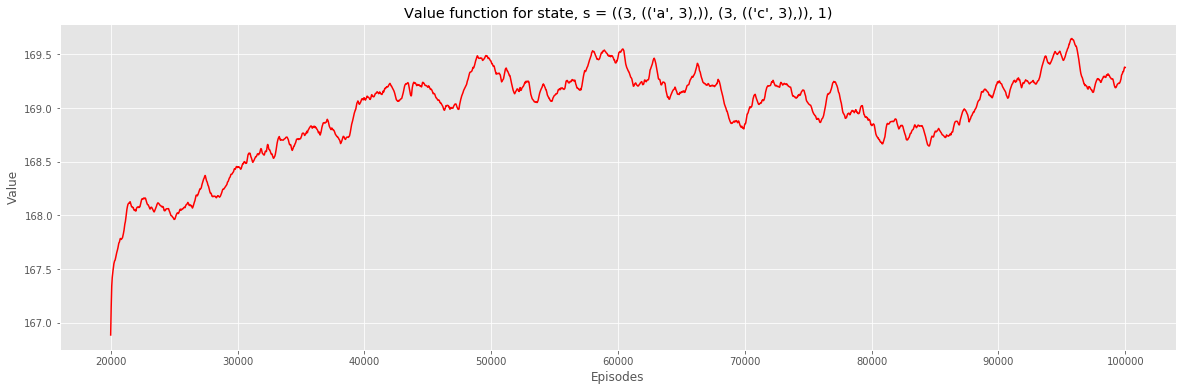

In [31]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(episode_value_func).rolling(20000, min_periods=20000).mean(), color='red')
plt.xlabel('Episodes')
plt.ylabel('Value')
plt.title("Value function for state, s = ((3, (('a', 3),)), (3, (('c', 3),)), 1)")
plt.savefig('value_function_mc.jpg', dpi=600)

In [32]:
print(episode_value_func)

[0.0, 0.0, 0.0, 13.200000000000001, 13.200000000000001, 13.200000000000001, 13.200000000000001, 13.200000000000001, 13.200000000000001, 30.080000000000005, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.130320

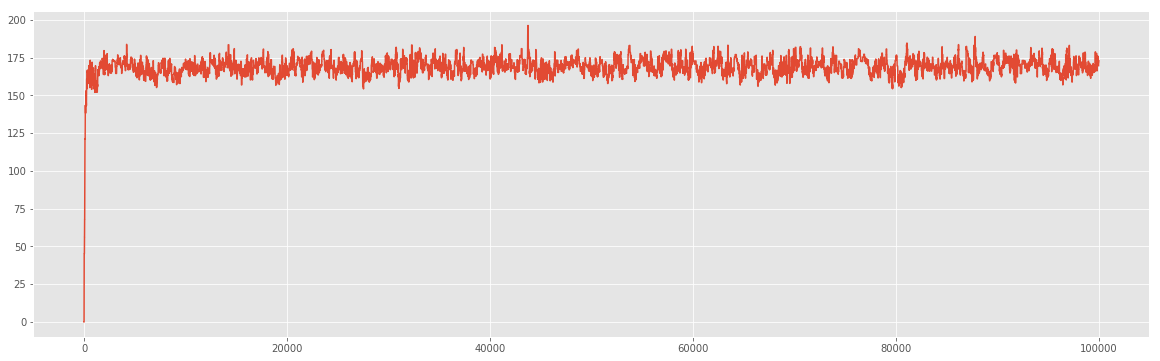

In [29]:
plt.figure(figsize=(20, 6))
plt.plot(episode_value_func)

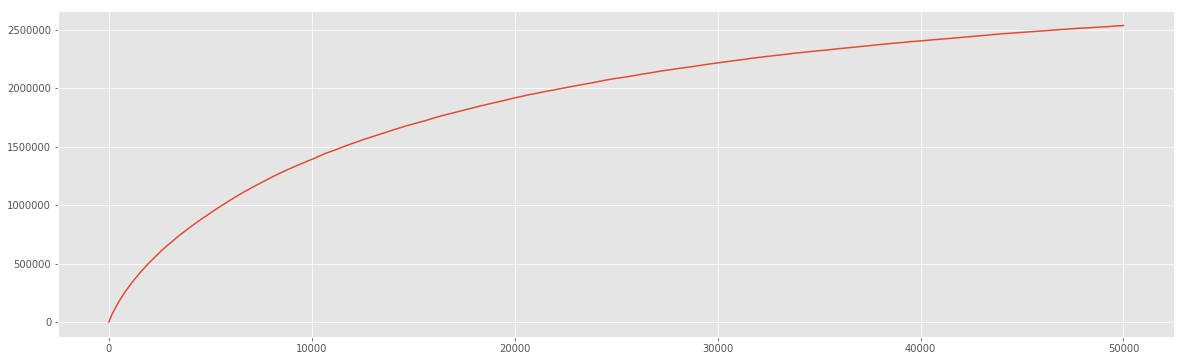

In [23]:
# plt.figure(figsize=(20, 6))
# plt.plot(episode_value_func)

In [7]:
# get policy
policy = {}
for key, value in q_func_1.items():
    policy[key] = np.argmax(value)

In [8]:
def random_policy(possible_actions):
    return np.random.choice(possible_actions)

def trained_policy(state, possible_actions, policy, movable_piece_board_pos):
    if state in policy:
        best_action = policy[state]
        if best_action in movable_piece_board_pos.keys():
            return movable_piece_board_pos[best_action]
        
    return np.random.choice(possible_actions)

def test_mc_agent(env, num_episodes, policy):
    player1 = 0 # trained
    player2 = 1 # random
    init_q_value = 0.0
    
    episode_rewards_p1 = [0.0]
    episode_rewards_p2 = [0.0]
    time_to_win = []
    for curr_episode in range(num_episodes):
        episode_transitions_p1 = list()
        episode_transitions_p2 = list()
        dice_up = env.roll()
        state = env.reset(dice_up)
        is_done = False
        t = 0
        
        while True:
            # player 1 move
            t += 1
            
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player1, dice_up)
            reward_p1 = 0
            if len(possible_actions) != 0:
                action = trained_policy(state, possible_actions, policy, movable_piece_board_pos)
                new_state, reward_p1, done, _ = env.step(action, dice_up)
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                episode_transitions_p1.append((state, action['board_pos'], reward_p1))
                state = copy.deepcopy(new_state)
                
                if done:
                    break
           
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player2, dice_up)
            reward_p2 = 0
            if len(possible_actions) != 0:
                action = random_policy(possible_actions)
                new_state, reward_p2, done, _ = env.step(action, dice_up)
                episode_transitions_p2.append((state, action['board_pos'], reward_p2))
                state = copy.deepcopy(new_state)

                if done:
                    break
            
            dice_up = env.roll()
        episode_rewards_p1[-1] =+ reward_p1
        episode_rewards_p1.append(0.0)
        
        episode_rewards_p2[-1] =+ reward_p2
        episode_rewards_p2.append(0.0)
        time_to_win.append(t)
        
    return episode_rewards_p1, episode_rewards_p2, time_to_win

In [10]:
test_episode_rewards_p1, test_episode_rewards_p2, test_time_to_win = test_mc_agent(env, 100, policy)

In [11]:
test_avg_trained = np.mean(test_episode_rewards_p1)
test_avg_random = np.mean(test_episode_rewards_p2)
print("Trained Score: ", test_avg_trained/(test_avg_random + test_avg_trained))
print("Random Score: ", test_avg_random/(test_avg_random + test_avg_trained))

Trained Score:  0.5783571077225775
Random Score:  0.4216428922774225


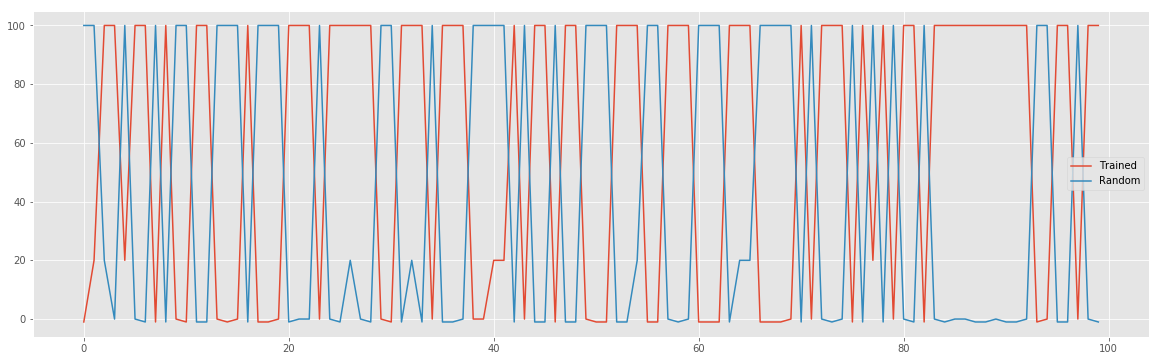

In [12]:
plt.figure(figsize=(20, 6))
trained, = plt.plot(test_episode_rewards_p1[:100], label='Trained')
random, = plt.plot(test_episode_rewards_p2[:100], label='Random')
plt.legend([trained, random], ['Trained', 'Random'])

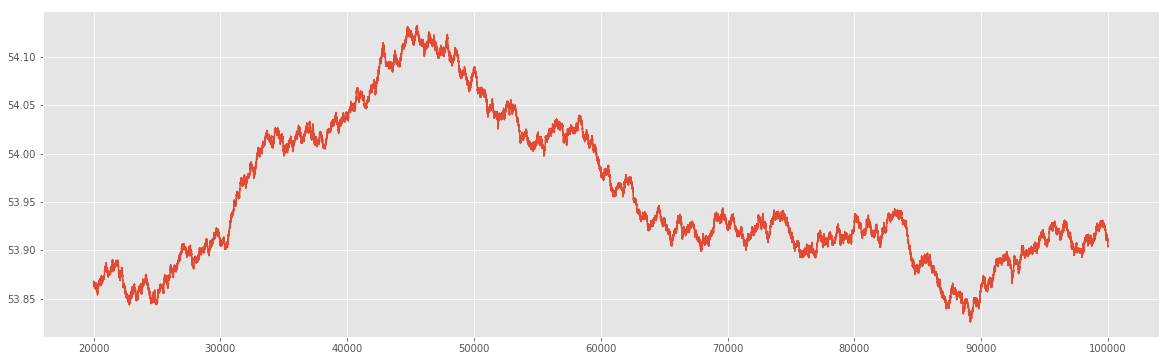

In [13]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(time_to_win).rolling(20000, min_periods=20000).mean())

In [16]:
print(time_to_win)

[60, 56, 68, 69, 46, 54, 72, 55, 67, 54, 65, 58, 69, 57, 54, 50, 45, 68, 52, 44, 42, 70, 58, 70, 48, 47, 50, 61, 49, 47, 44, 61, 56, 42, 64, 51, 63, 50, 56, 50, 53, 49, 53, 73, 57, 51, 55, 61, 61, 58, 49, 45, 60, 60, 42, 52, 63, 47, 54, 47, 67, 55, 46, 46, 52, 64, 54, 52, 58, 56, 59, 47, 50, 59, 52, 59, 47, 57, 65, 64, 62, 53, 55, 56, 46, 54, 50, 56, 49, 55, 44, 43, 48, 57, 56, 57, 46, 45, 43, 53, 62, 46, 57, 44, 59, 44, 50, 66, 58, 54, 55, 44, 57, 65, 52, 56, 48, 41, 48, 46, 66, 42, 54, 51, 63, 58, 51, 69, 48, 39, 65, 52, 50, 43, 51, 46, 56, 59, 64, 63, 54, 48, 54, 42, 65, 61, 51, 55, 54, 56, 55, 44, 47, 56, 51, 48, 76, 60, 53, 65, 49, 62, 65, 56, 57, 54, 45, 54, 60, 62, 68, 61, 51, 43, 56, 68, 53, 47, 47, 53, 51, 51, 77, 61, 52, 48, 50, 40, 42, 61, 53, 48, 42, 56, 45, 63, 62, 54, 44, 39, 56, 68, 55, 59, 67, 48, 47, 53, 61, 56, 54, 52, 48, 49, 51, 60, 56, 44, 73, 51, 38, 57, 52, 50, 58, 43, 56, 63, 62, 40, 58, 53, 65, 52, 58, 52, 57, 46, 64, 44, 42, 49, 51, 59, 67, 55, 49, 55, 58, 47,

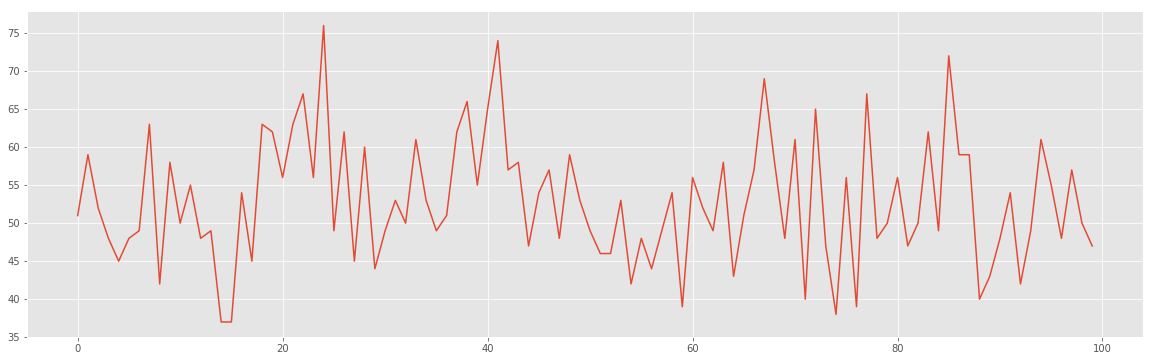

In [14]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(test_time_to_win).rolling(1, min_periods=1).mean())

In [36]:
p1_mean_rwds = np.mean(np.array(episode_rwds_p1[-1]).reshape(1, -1), axis=0)
p2_mean_rwds = np.mean(np.array(episode_rwds_p2[-1]).reshape(1, -1), axis=0)

In [22]:
# plt.figure(figsize=(20, 6))
# plt.plot(p1_mean_rwds[-100:])

In [23]:
# plt.figure(figsize=(20, 6))
# plt.plot(p2_mean_rwds[-100:])

In [24]:
# plt.figure(figsize=(20, 6))
# plt.plot(p1_mean_rwds[-100:])
# plt.plot(p2_mean_rwds[-100:])

In [13]:
# plt.figure(figsize=(20, 6))
# plt.plot(pd.Series(p1_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())
# plt.plot(pd.Series(p2_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())

In [15]:
policy

{((4, ()), (4, ()), 2): 5,
 ((3, (('a', 3),)), (4, ()), 2): 3,
 ((3, (('a', 3),)), (3, (('c', 3),)), 1): 3,
 ((2, (('a', 3), ('a', 4))), (3, (('c', 3),)), 1): 21,
 ((2, (('a', 3), ('a', 4))), (2, (('c', 3), ('c', 4))), 2): 3,
 ((2, (('a', 2), ('a', 3))), (2, (('c', 3), ('c', 4))), 2): 19,
 ((2, (('a', 2), ('a', 3))), (2, (('c', 1), ('c', 4))), 1): 21,
 ((1, (('a', 2), ('a', 3), ('a', 4))), (2, (('c', 1), ('c', 4))), 2): 21,
 ((1, (('a', 2), ('a', 3), ('a', 4))), (2, (('c', 1), ('c', 2))), 2): 21,
 ((1, (('a', 1), ('a', 2), ('a', 4))), (2, (('c', 1), ('c', 2))), 2): 4,
 ((1, (('a', 1), ('a', 2), ('a', 4))), (2, (('b', 2), ('c', 2))), 1): 2,
 ((1, (('a', 1), ('a', 2), ('a', 3))), (2, (('b', 2), ('c', 2))), 1): 5,
 ((1, (('a', 1), ('a', 2), ('a', 3))),
  (1, (('b', 2), ('c', 2), ('c', 4))),
  1): 1,
 ((0, (('a', 1), ('a', 2), ('a', 3), ('a', 4))),
  (1, (('b', 2), ('c', 2), ('c', 4))),
  1): 1,
 ((0, (('a', 1), ('a', 2), ('a', 3), ('a', 4))),
  (1, (('b', 2), ('c', 1), ('c', 4))),
  1): 1

In [26]:
q_func_1

defaultdict(<function __main__.train_mc_agent.<locals>.<lambda>>,
            {((4, ()),
              (4, ()),
              2): array([  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
                    164.1143611,   0.       ,   0.       ,   0.       ,   0.       ,
                      0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
                      0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
                      0.       , 164.1143611,   0.       ,   0.       ,   0.       ]),
             ((3, (('a', 3),)),
              (4, ()),
              2): array([  0.        ,   0.        ,   0.        , 155.39094372,
                      0.        , 172.59584925,   0.        ,   0.        ,
                      0.        ,   0.        ,   0.        ,   0.        ,
                      0.        ,   0.        ,   0.        ,   0.        ,
                      0.        ,   0.        ,   0.        ,   0.        ,
                